In [ ]:
# Install Modules

!pip install -U LibRecommender
!pip install libreco
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement libreco (from versions: none)
ERROR: No matching distribution found for libreco


In [ ]:
# IMport Modules

import random
import warnings
import zipfile
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm

warnings.filterwarnings("ignore")

In [ ]:
# Load Base folder

from google.colab import drive
drive.mount('/content/drive')

BASE_FOLDER = '/content/drive/MyDrive/ProjectDatasets'

Mounted at /content/drive


In [ ]:
## Bring in the Data

def load_ml_1m():
    # download and extract zip file
    tf.keras.utils.get_file(
        "ml-1m.zip",
        "http://files.grouplens.org/datasets/movielens/ml-1m.zip",
        cache_dir=".",
        cache_subdir=".",
        extract=True,
    )

    # read and merge data into same table
    cur_path = Path(".").absolute()

    #Ratings
    ratings = pd.read_csv(
        cur_path / "ml-1m" / "ratings.dat",
        sep="::",
        usecols=[0, 1, 2, 3],
        names=["user", "item", "rating", "time"],
    )

    #Users
    users = pd.read_csv(
        cur_path / "ml-1m" / "users.dat",
        sep="::",
        usecols=[0, 1, 2, 3],
        names=["user", "sex", "age", "occupation"],
    )

    # Movies
    items = pd.read_csv(
        cur_path / "ml-1m" / "movies.dat",
        sep="::",
        usecols=[0, 2],
        names=["item", "genre"],
        encoding="iso-8859-1",
    )

    items[["genre1", "genre2", "genre3"]] = (
        items["genre"].str.split(r"|", expand=True).fillna("missing").iloc[:, :3]
    )

    # Remove Duplicates
    items.drop("genre", axis=1, inplace=True)

    #Merged Data
    data = ratings.merge(users, on="user").merge(items, on="item")

    #Rename Rating Here as Label
    data.rename(columns={"rating": "label"}, inplace=True)

    #data = pd.merge(data, reviews, on='item')

    # random shuffle data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    return data

data = load_ml_1m()

5917549/5917549 [==============================] - 0s 0us/step


In [ ]:
data = load_ml_1m()
print("data shape:", data.shape)

data shape: (1000209, 10)


In [ ]:
data.iloc[random.choices(range(len(data)), k=10)]  # randomly select 10 rows

,user,item,label,time,sex,age,occupation,genre1,genre2,genre3
785776,4980,3246,4,962603804,M,25,1,Drama,missing,missing
924959,2570,2858,3,973911865,F,56,14,Comedy,Drama,missing
824137,5686,898,2,958688096,M,56,16,Comedy,Romance,missing
889482,676,466,4,975650215,M,18,16,Action,Comedy,War
845476,4326,3108,5,965245152,F,45,13,Comedy,Drama,Romance
940154,875,562,5,975271282,M,1,10,Comedy,Drama,missing
906176,2446,2174,4,974404994,M,18,7,Comedy,Fantasy,missing
838470,1560,2944,4,998153908,F,25,3,Action,War,missing
664137,352,802,4,976333315,M,18,4,Drama,Romance,missing
980869,5644,527,5,958880791,F,18,4,Drama,War,missing


Load Dataset (with sentiment scores)

In [13]:
final_data = pd.read_csv('/content/drive/MyDrive/ProjectDatasets/imdb/scored/one_million_df_with_scores.csv') # file with sentiment scores

In [14]:
# Check the shape
final_data.shape

(1000191, 11)

Scores vs MovieID Distribution

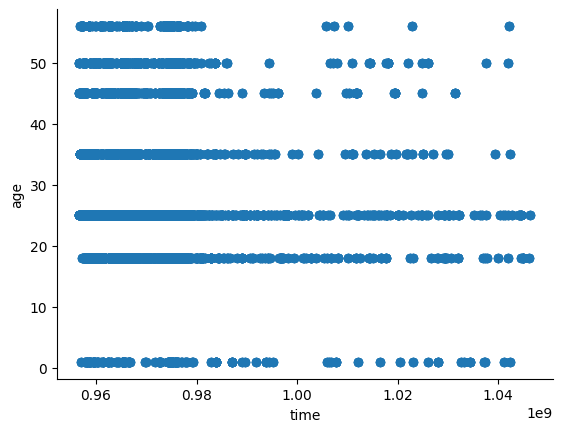

In [ ]:
from matplotlib import pyplot as plt
final_data.plot(kind='scatter', x='time', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [33]:
final_data.sample(10)

,user,item,age,genre1,genre2,genre3,label,occupation,scores,sex,time
247728,1697,2058,18,Action,Thriller,missing,4,4,4,F,974709601
658443,2868,3578,35,Action,Drama,missing,4,12,0,M,992717649
47693,3378,3701,18,Crime,Drama,Sci-Fi,4,4,3,M,967757530
874973,4607,1404,25,Crime,Drama,missing,3,0,1,M,998919752
417766,3311,2082,25,Children's,Comedy,missing,3,4,0,M,967959719
698969,1722,3017,35,Horror,missing,missing,3,0,0,M,974707112
25084,451,904,56,Mystery,Thriller,missing,5,13,0,M,976415003
374132,3526,387,35,Action,Comedy,missing,3,2,3,M,966904746
328308,2907,3507,35,Comedy,missing,missing,4,5,1,F,971841563
618085,1850,48,18,Animation,Children's,Musical,4,5,2,M,974697762


# SPlit Data

In [16]:
# SPlit Data

from libreco.data import random_split

# split data into three folds for training, evaluating and testing
first_half_data = final_data[: (len(final_data) // 2)] #I am using Full Data
train_data, eval_data, test_data = random_split(first_half_data, multi_ratios=[0.6, 0.2, 0.2], seed=42)

In [17]:
print("first half data shape:", first_half_data.shape)

first half data shape: (500095, 11)


In [18]:
from libreco.data import DatasetFeat

sparse_col = ["sex", "occupation", "genre1", "genre2", "genre3"]
# dense_col = ["age", "label"] # Without Sentiment Analysis
dense_col = ["age", "label", "scores"] # With sentiment analysis Scores
# user_col = ["sex", "age", "label", "occupation"] # Without Sentiment analysis scores
user_col = ["sex", "age", "label", "scores", "occupation"] # With Sentiment analysis scores
item_col = ["genre1", "genre2", "genre3"]

train_data, data_info = DatasetFeat.build_trainset(train_data, user_col, item_col, sparse_col, dense_col)
eval_data = DatasetFeat.build_evalset(eval_data)
test_data = DatasetFeat.build_testset(test_data)

In [ ]:
print(type(train_data))

<class 'libreco.data.transformed.TransformedSet'>


In [19]:
print(data_info)

n_users: 6040, n_items: 3535, data density: 1.4053 %


In [20]:
#Import DeepFM
from libreco.algorithms import DeepFM

tf.compat.v1.reset_default_graph()

# n_epochs=4,
# dropout_rate=None,

model = DeepFM(
    task="ranking",             # Use ranking task if appropriate
    data_info=data_info,        # Provide dataset information
    loss_type="cross_entropy",  # Use cross-entropy loss for classification tasks
    embed_size=16,              # Size of embedding vectors = 16 or 8
    n_epochs= 12,                # Increase the number of epochs for larger datasets - 5 or 12
    lr=0.001,                    # Adjust learning rate accordingly 1e-4 or 0.001 or 2e-5
    lr_decay=True,              # Enable learning rate decay for better convergence
    reg=None,                  # Apply regularization to prevent overfitting
    batch_size=1024,            # Adjust batch size based on available memory = 512 or 2048 or 1024
    num_neg=1,                  # Increase the number of negative samples for ranking tasks
    use_bn=True,                # Use batch normalization to stabilize training
    dropout_rate=None,           # Apply dropout regularization to prevent overfitting
    hidden_units=(256, 128, 64), # Increase the size of hidden layers for more capacity
    tf_sess_config=None,         # Use default TensorFlow session configuration
)

# Fit Model

model.fit(
    train_data=train_data,
    neg_sampling=True,  # perform negative sampling on training and eval data
    verbose=2,
    shuffle=True,
    eval_data=eval_data,
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)

Instructions for updating:
non-resource variables are not supported in the long term


Training start time: 2024-04-16 00:32:51


Instructions for updating:
Colocations handled automatically by placer.


total params: 247,769 | embedding params: 164,670 | network params: 83,099
With lr_decay, epoch 1 learning rate: 0.0010000000474974513


train: 100%|██████████| 587/587 [00:15<00:00, 36.89it/s]


Epoch 1 elapsed: 15.919s
	 train_loss: 0.6374


eval_listwise: 100%|██████████| 2974/2974 [02:15<00:00, 21.94it/s]


	 eval log_loss: 0.5370
	 eval balanced_accuracy: 0.7296
	 eval roc_auc: 0.8023
	 eval pr_auc: 0.7748
	 eval precision@10: 0.0480
	 eval recall@10: 0.0406
	 eval map@10: 0.1200
	 eval ndcg@10: 0.1783
With lr_decay, epoch 2 learning rate: 0.0009600000339560211


train: 100%|██████████| 587/587 [00:14<00:00, 41.42it/s]


Epoch 2 elapsed: 14.178s
	 train_loss: 0.4678


eval_listwise: 100%|██████████| 2974/2974 [02:16<00:00, 21.87it/s]


	 eval log_loss: 0.5277
	 eval balanced_accuracy: 0.7486
	 eval roc_auc: 0.8253
	 eval pr_auc: 0.7991
	 eval precision@10: 0.0510
	 eval recall@10: 0.0438
	 eval map@10: 0.1294
	 eval ndcg@10: 0.1901
With lr_decay, epoch 3 learning rate: 0.0009216000325977802


train: 100%|██████████| 587/587 [00:14<00:00, 41.79it/s]


Epoch 3 elapsed: 14.057s
	 train_loss: 0.4423


eval_listwise: 100%|██████████| 2974/2974 [02:15<00:00, 22.02it/s]


	 eval log_loss: 0.5104
	 eval balanced_accuracy: 0.7592
	 eval roc_auc: 0.8338
	 eval pr_auc: 0.8079
	 eval precision@10: 0.0551
	 eval recall@10: 0.0494
	 eval map@10: 0.1329
	 eval ndcg@10: 0.1990
With lr_decay, epoch 4 learning rate: 0.000884735956788063


train: 100%|██████████| 587/587 [00:14<00:00, 40.55it/s]


Epoch 4 elapsed: 14.487s
	 train_loss: 0.4267


eval_listwise: 100%|██████████| 2974/2974 [02:14<00:00, 22.16it/s]


	 eval log_loss: 0.5148
	 eval balanced_accuracy: 0.7585
	 eval roc_auc: 0.8357
	 eval pr_auc: 0.8091
	 eval precision@10: 0.0546
	 eval recall@10: 0.0488
	 eval map@10: 0.1368
	 eval ndcg@10: 0.2003
With lr_decay, epoch 5 learning rate: 0.0008493465138599277


train: 100%|██████████| 587/587 [00:14<00:00, 41.02it/s]


Epoch 5 elapsed: 14.316s
	 train_loss: 0.4162


eval_listwise: 100%|██████████| 2974/2974 [02:15<00:00, 22.00it/s]


	 eval log_loss: 0.5118
	 eval balanced_accuracy: 0.7622
	 eval roc_auc: 0.8406
	 eval pr_auc: 0.8162
	 eval precision@10: 0.0583
	 eval recall@10: 0.0530
	 eval map@10: 0.1466
	 eval ndcg@10: 0.2144
With lr_decay, epoch 6 learning rate: 0.0008153726230375469


train: 100%|██████████| 587/587 [00:14<00:00, 41.76it/s]


Epoch 6 elapsed: 14.065s
	 train_loss: 0.4042


eval_listwise: 100%|██████████| 2974/2974 [02:14<00:00, 22.18it/s]


	 eval log_loss: 0.5247
	 eval balanced_accuracy: 0.7627
	 eval roc_auc: 0.8408
	 eval pr_auc: 0.8169
	 eval precision@10: 0.0591
	 eval recall@10: 0.0546
	 eval map@10: 0.1442
	 eval ndcg@10: 0.2142
With lr_decay, epoch 7 learning rate: 0.0007827577646821737


train: 100%|██████████| 587/587 [00:14<00:00, 41.31it/s]


Epoch 7 elapsed: 14.216s
	 train_loss: 0.3952


eval_listwise: 100%|██████████| 2974/2974 [02:14<00:00, 22.06it/s]


	 eval log_loss: 0.5312
	 eval balanced_accuracy: 0.7644
	 eval roc_auc: 0.8403
	 eval pr_auc: 0.8154
	 eval precision@10: 0.0557
	 eval recall@10: 0.0490
	 eval map@10: 0.1363
	 eval ndcg@10: 0.2011
With lr_decay, epoch 8 learning rate: 0.0007514473982155323


train: 100%|██████████| 587/587 [00:14<00:00, 41.65it/s]


Epoch 8 elapsed: 14.099s
	 train_loss: 0.3869


eval_listwise: 100%|██████████| 2974/2974 [02:13<00:00, 22.20it/s]


	 eval log_loss: 0.5449
	 eval balanced_accuracy: 0.7587
	 eval roc_auc: 0.8409
	 eval pr_auc: 0.8174
	 eval precision@10: 0.0593
	 eval recall@10: 0.0544
	 eval map@10: 0.1445
	 eval ndcg@10: 0.2141
With lr_decay, epoch 9 learning rate: 0.000721389485988766


train: 100%|██████████| 587/587 [00:14<00:00, 41.60it/s]


Epoch 9 elapsed: 14.121s
	 train_loss: 0.3786


eval_listwise: 100%|██████████| 2974/2974 [02:14<00:00, 22.19it/s]


	 eval log_loss: 0.5548
	 eval balanced_accuracy: 0.7610
	 eval roc_auc: 0.8412
	 eval pr_auc: 0.8174
	 eval precision@10: 0.0586
	 eval recall@10: 0.0539
	 eval map@10: 0.1407
	 eval ndcg@10: 0.2099
With lr_decay, epoch 10 learning rate: 0.0006925339112058282


train: 100%|██████████| 587/587 [00:14<00:00, 41.84it/s]


Epoch 10 elapsed: 14.036s
	 train_loss: 0.3713


eval_listwise: 100%|██████████| 2974/2974 [02:14<00:00, 22.12it/s]


	 eval log_loss: 0.5684
	 eval balanced_accuracy: 0.7616
	 eval roc_auc: 0.8418
	 eval pr_auc: 0.8185
	 eval precision@10: 0.0582
	 eval recall@10: 0.0537
	 eval map@10: 0.1415
	 eval ndcg@10: 0.2093
With lr_decay, epoch 11 learning rate: 0.0006648324779234827


train: 100%|██████████| 587/587 [00:14<00:00, 41.50it/s]


Epoch 11 elapsed: 14.154s
	 train_loss: 0.3651


eval_listwise: 100%|██████████| 2974/2974 [02:14<00:00, 22.09it/s]


	 eval log_loss: 0.5709
	 eval balanced_accuracy: 0.7651
	 eval roc_auc: 0.8423
	 eval pr_auc: 0.8184
	 eval precision@10: 0.0579
	 eval recall@10: 0.0542
	 eval map@10: 0.1389
	 eval ndcg@10: 0.2076
With lr_decay, epoch 12 learning rate: 0.0006382392020896077


train: 100%|██████████| 587/587 [00:14<00:00, 40.33it/s]


Epoch 12 elapsed: 14.562s
	 train_loss: 0.3592


eval_listwise: 100%|██████████| 2974/2974 [02:19<00:00, 21.32it/s]


	 eval log_loss: 0.5995
	 eval balanced_accuracy: 0.7626
	 eval roc_auc: 0.8440
	 eval pr_auc: 0.8209
	 eval precision@10: 0.0583
	 eval recall@10: 0.0545
	 eval map@10: 0.1478
	 eval ndcg@10: 0.2165


In [21]:
# Evaluate Test Data

from libreco.evaluation import evaluate

evaluate(
    model=model,
    data=test_data,
    neg_sampling=True,  # No negative sampling on test data
    metrics=[
            "loss",
            "balanced_accuracy",
            "roc_auc",
            "pr_auc",
            "precision",
            "recall",
            "map",
            "ndcg",
        ],
)


eval_listwise: 100%|██████████| 2982/2982 [01:58<00:00, 25.10it/s]


{'loss': 0.5998284481063995,
 'balanced_accuracy': 0.7635996238721166,
 'roc_auc': 0.8446872540869326,
 'pr_auc': 0.8213677952542983,
 'precision': 0.05916484990776455,
 'recall': 0.054060672264152454,
 'map': 0.13982615619398056,
 'ndcg': 0.2096141353701751}

Plots

In [26]:
# predict preference of user 87711 to item 110
# model.predict(user=87711, item=1690)

# Make Recommendation
# model.recommend_user(user=1, n_rec=3)

# Make temporary recommendations based on User features
model.recommend_user(user=10, n_rec=10, user_feats={"sex": "M", "age": 33})

{10: array([ 260,  480, 1198, 1580,    1, 1196, 2028, 1214, 1270, 1210])}

In [23]:
data_info.save("/content/drive/MyDrive/ProjectDatasets/", model_name="deep_fm_enhanced")
model.save("/content/drive/MyDrive/ProjectDatasets/", model_name="deep_fm_enhanced")